In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias
from exp_hp import get_hp

2024-08-08 12:53:03.430709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 12:53:04.386664: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Test NN

Training Members: ['0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181', '0191']
Validation Member: 0201
Testing Member: 0101
files do not exist - loading data & saving


2024-08-08 12:56:00.409749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 0s 1ms/step


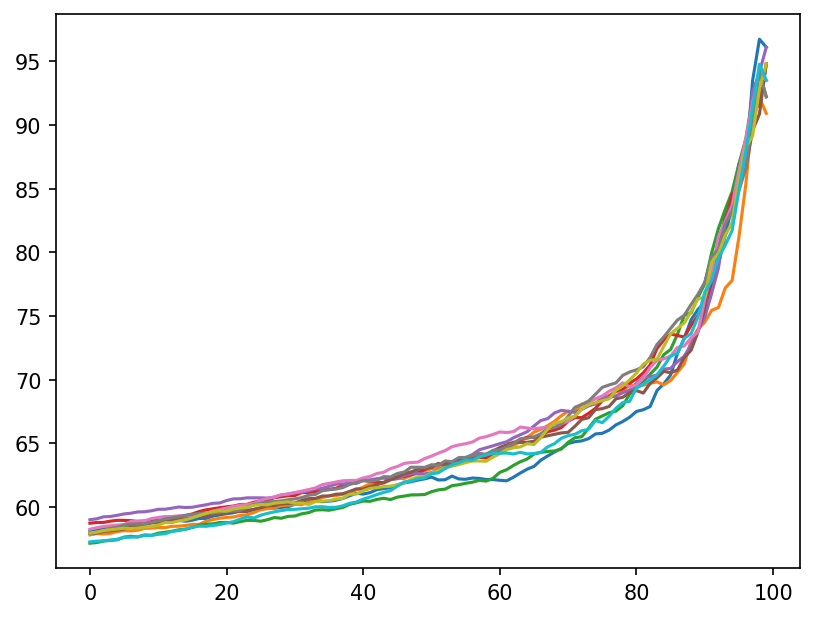

Training Members: ['0121', '0131', '0141', '0151', '0161', '0171', '0181', '0191', '0201']
Validation Member: 0211
Testing Member: 0111
files do not exist - loading data & saving
223/223 [==============================] - 1s 2ms/step


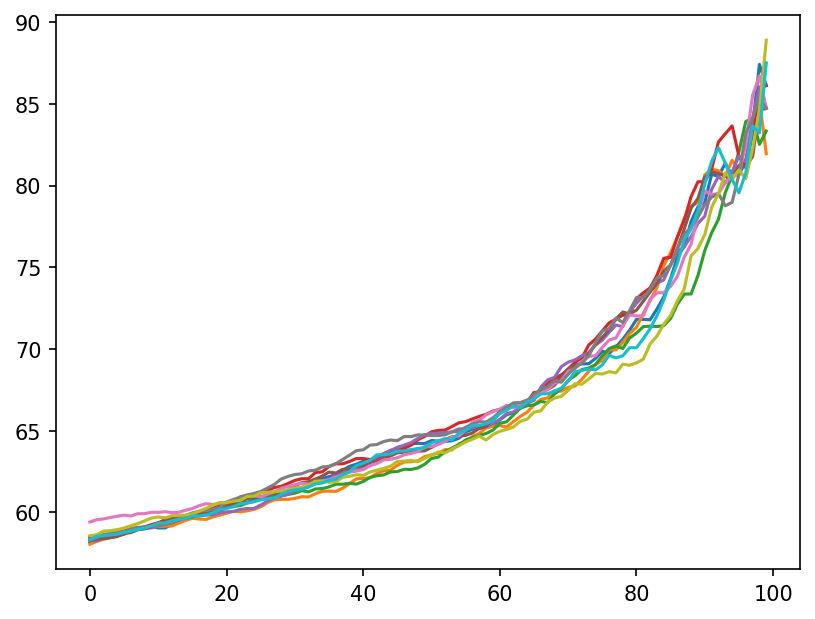

Training Members: ['0131', '0141', '0151', '0161', '0171', '0181', '0191', '0201', '0211']
Validation Member: 0221
Testing Member: 0121
files do not exist - loading data & saving
239/239 [==============================] - 0s 1ms/step


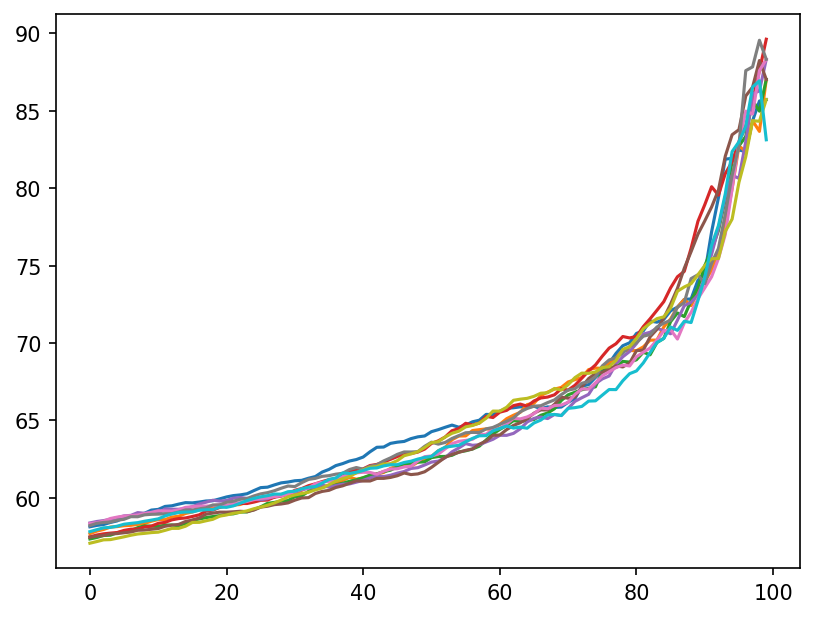

Training Members: ['0141', '0151', '0161', '0171', '0181', '0191', '0201', '0211', '0221']
Validation Member: 0231
Testing Member: 0131
files do not exist - loading data & saving
231/231 [==============================] - 1s 2ms/step


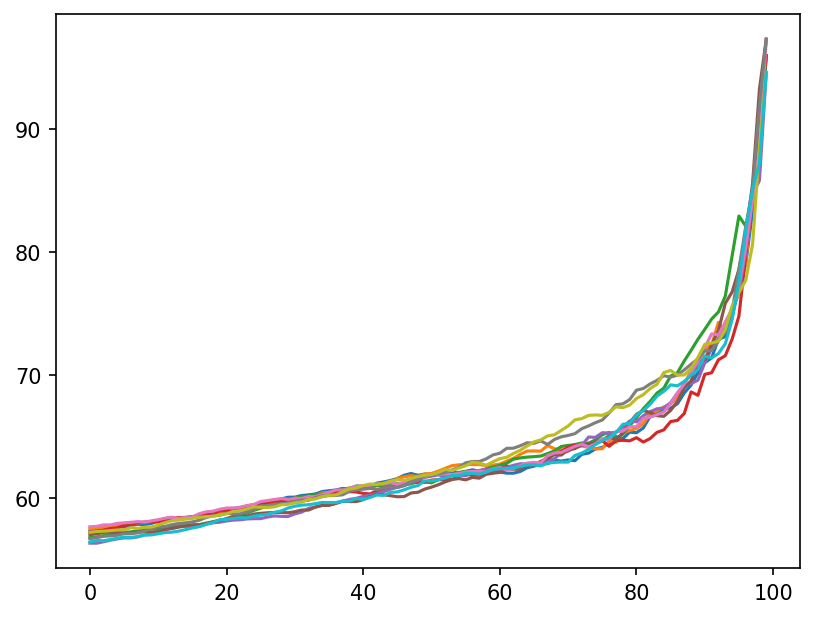

Training Members: ['0151', '0161', '0171', '0181', '0191', '0201', '0211', '0221', '0231']
Validation Member: 0241
Testing Member: 0141
files do not exist - loading data & saving
234/234 [==============================] - 1s 2ms/step


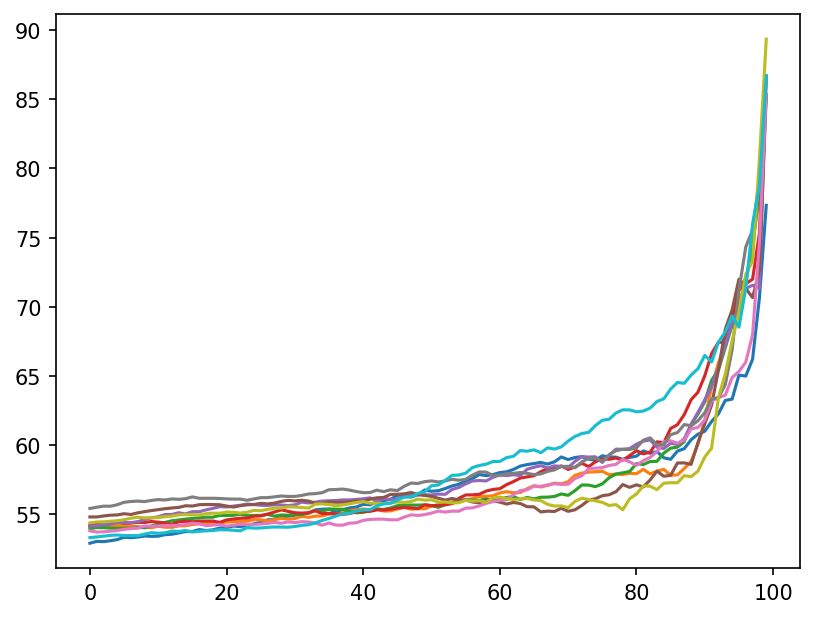

Training Members: ['0161', '0171', '0181', '0191', '0201', '0211', '0221', '0231', '0241']
Validation Member: 0251
Testing Member: 0151
files do not exist - loading data & saving
242/242 [==============================] - 0s 1ms/step


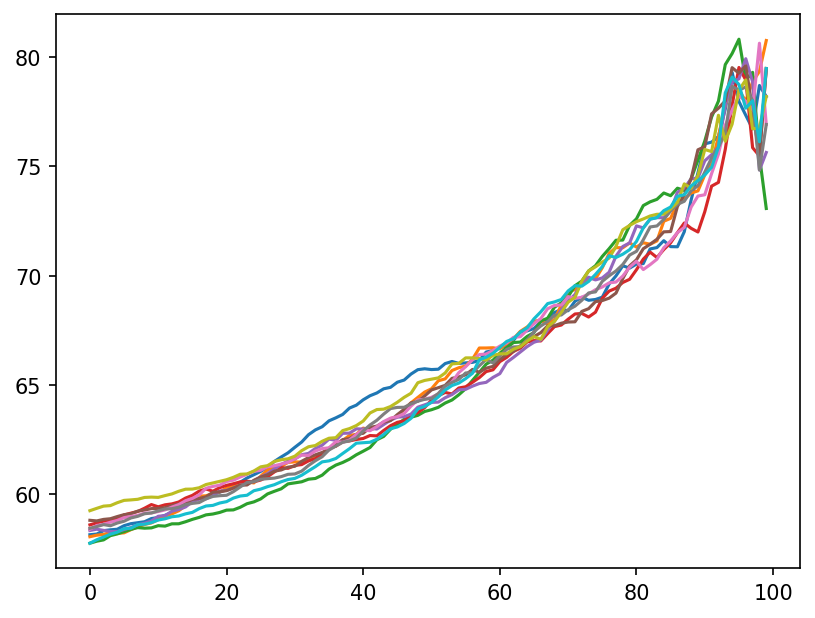

Training Members: ['0171', '0181', '0191', '0201', '0211', '0221', '0231', '0241', '0251']
Validation Member: 0261
Testing Member: 0161
files do not exist - loading data & saving
233/233 [==============================] - 1s 2ms/step


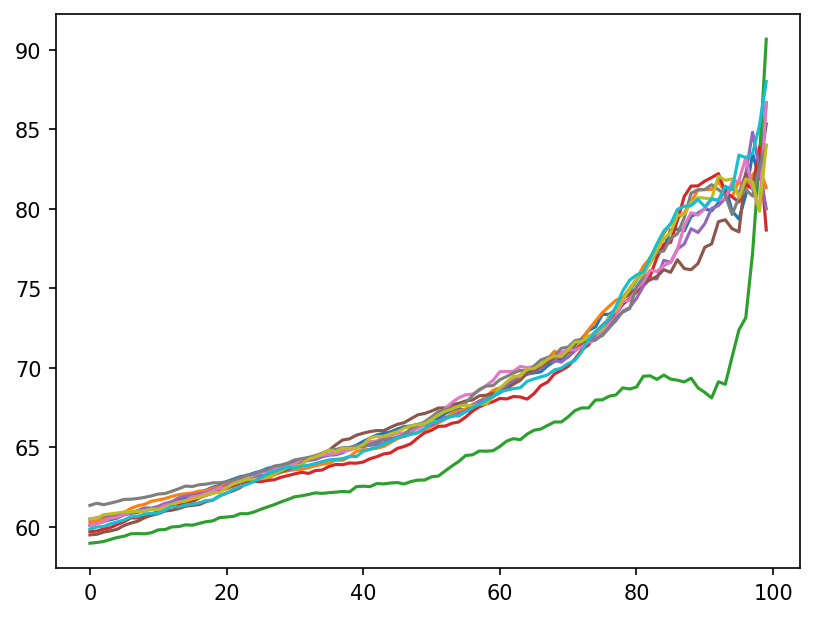

Training Members: ['0181', '0191', '0201', '0211', '0221', '0231', '0241', '0251', '0261']
Validation Member: 0271
Testing Member: 0171
files do not exist - loading data & saving
210/210 [==============================] - 1s 2ms/step


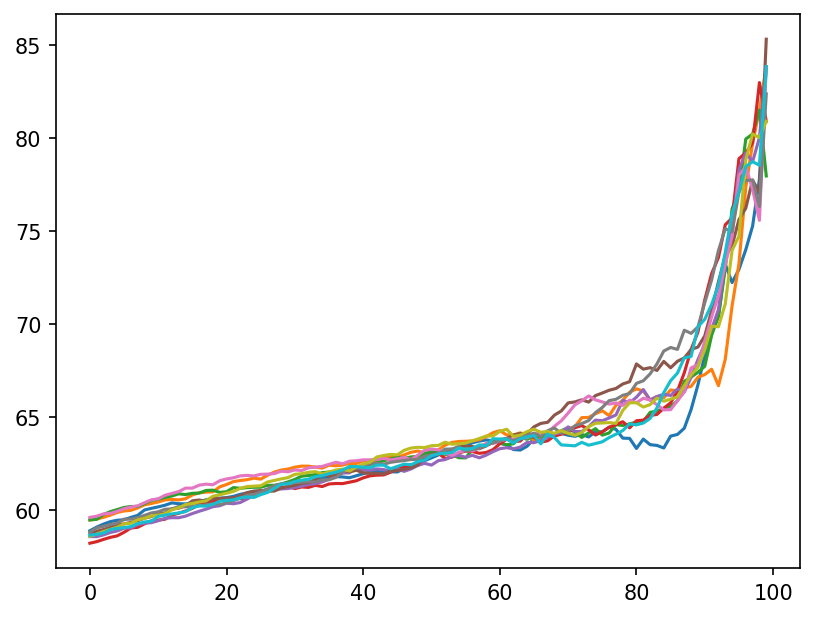

Training Members: ['0191', '0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271']
Validation Member: 0281
Testing Member: 0181
files do not exist - loading data & saving
236/236 [==============================] - 0s 818us/step


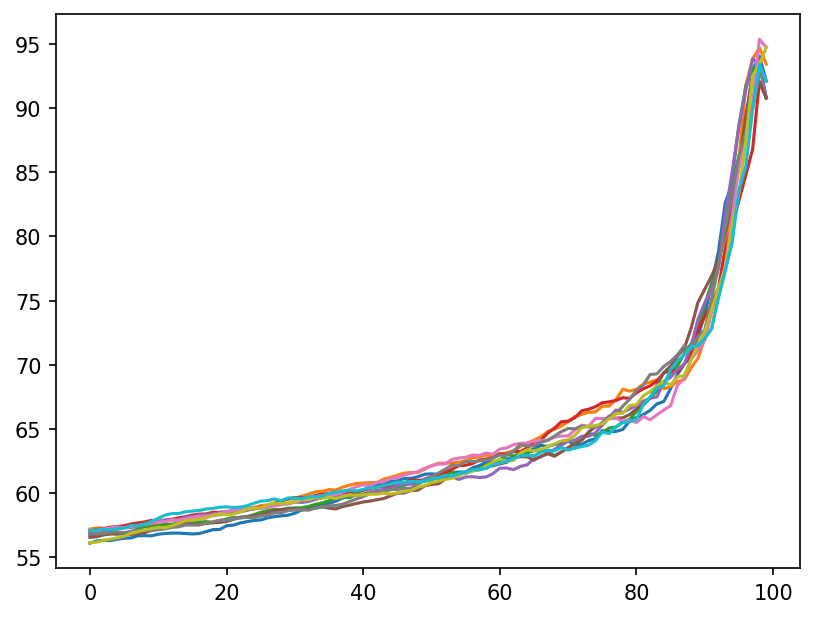

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0191
files do not exist - loading data & saving
241/241 [==============================] - 0s 2ms/step


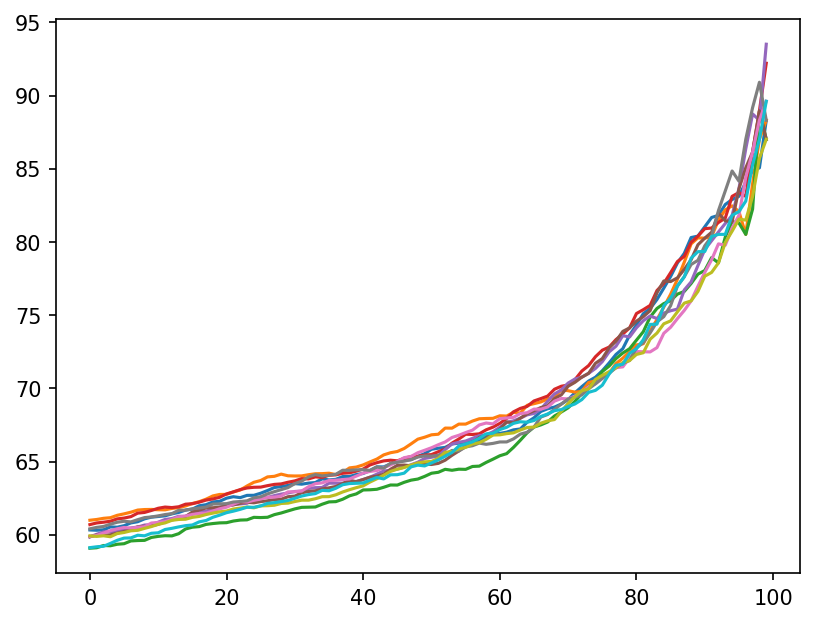

Training Members: ['0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281', '0291']
Validation Member: 0301
Testing Member: 0201
files do not exist - loading data & saving
225/225 [==============================] - 0s 810us/step


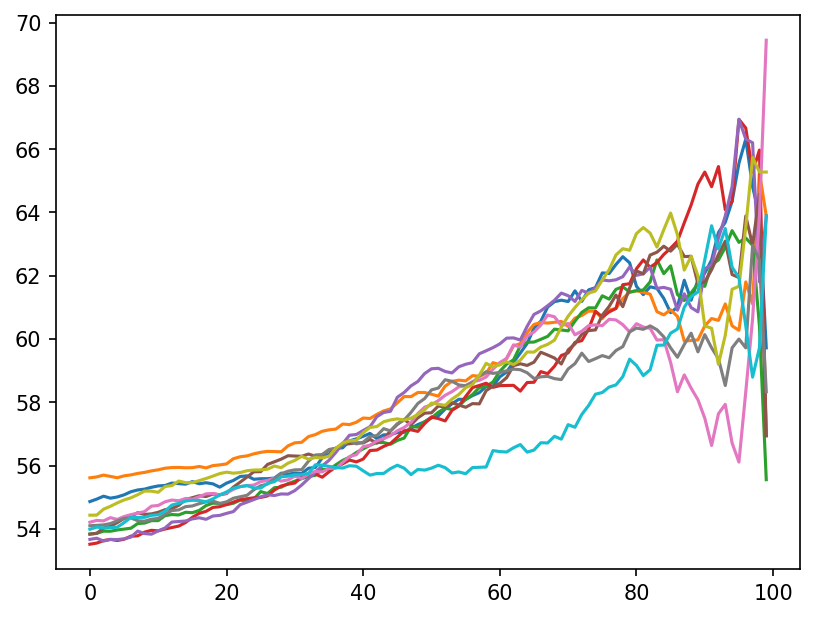

Training Members: ['0221', '0231', '0241', '0251', '0261', '0271', '0281', '0291', '0301']
Validation Member: 0101
Testing Member: 0211
files do not exist - loading data & saving
242/242 [==============================] - 0s 1ms/step


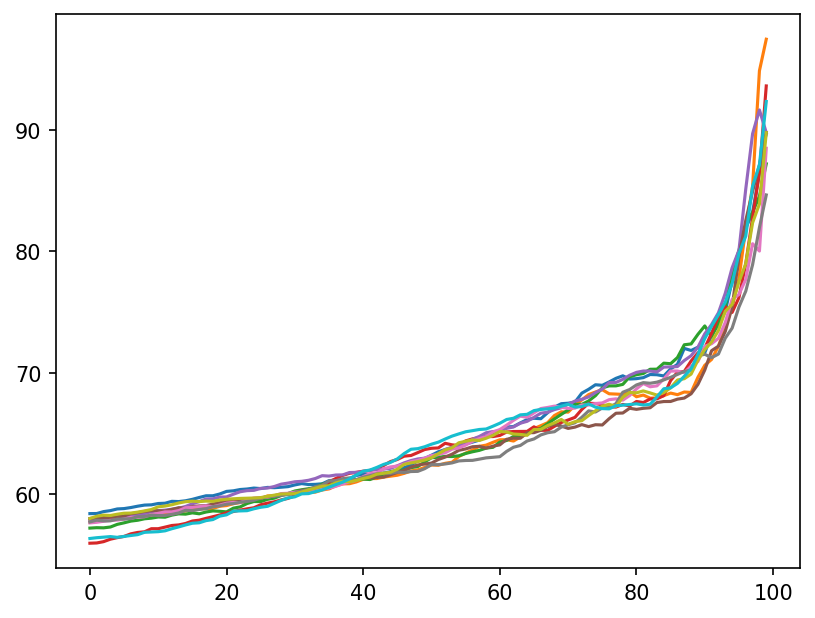

Training Members: ['0231', '0241', '0251', '0261', '0271', '0281', '0291', '0301', '0101']
Validation Member: 0111
Testing Member: 0221
files do not exist - loading data & saving
238/238 [==============================] - 0s 902us/step


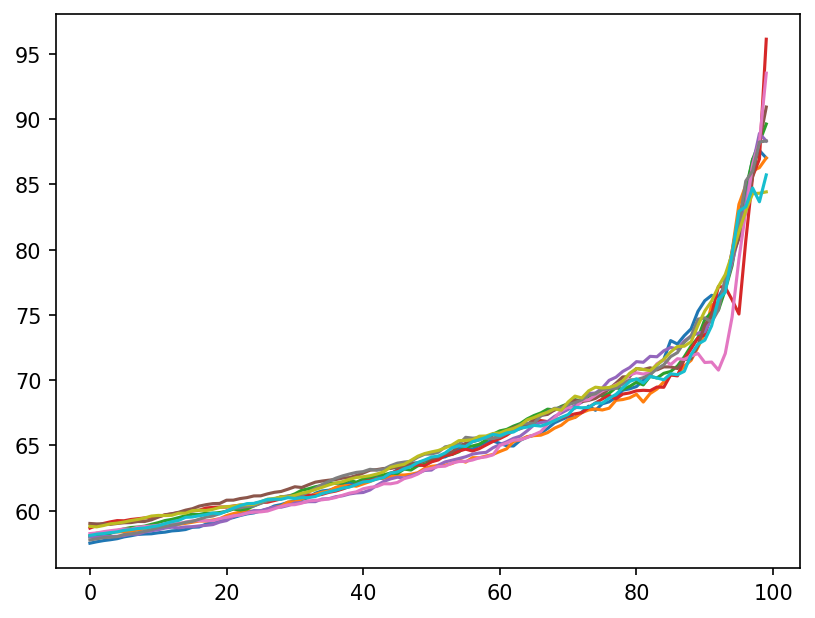

Training Members: ['0241', '0251', '0261', '0271', '0281', '0291', '0301', '0101', '0111']
Validation Member: 0121
Testing Member: 0231
files do not exist - loading data & saving
241/241 [==============================] - 1s 2ms/step


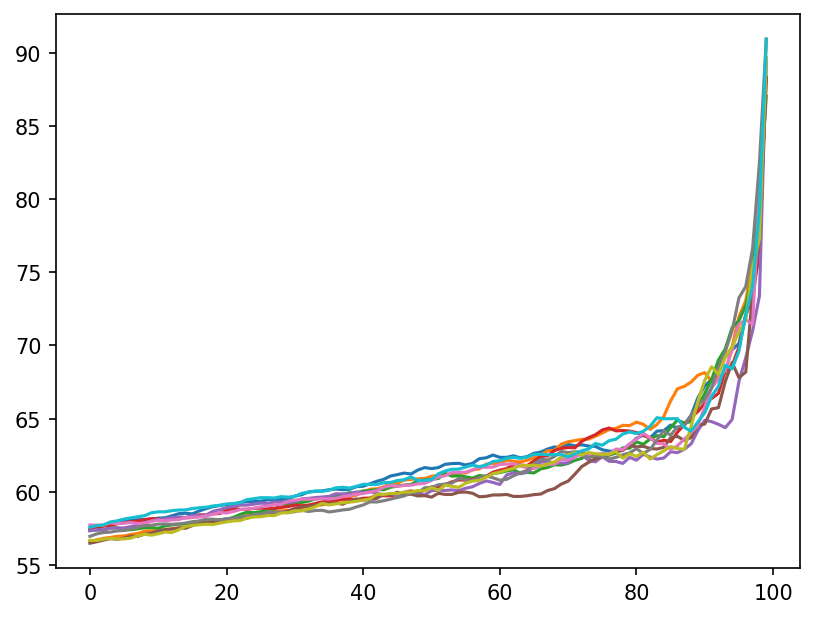

Training Members: ['0251', '0261', '0271', '0281', '0291', '0301', '0101', '0111', '0121']
Validation Member: 0131
Testing Member: 0241
files do not exist - loading data & saving
225/225 [==============================] - 0s 817us/step


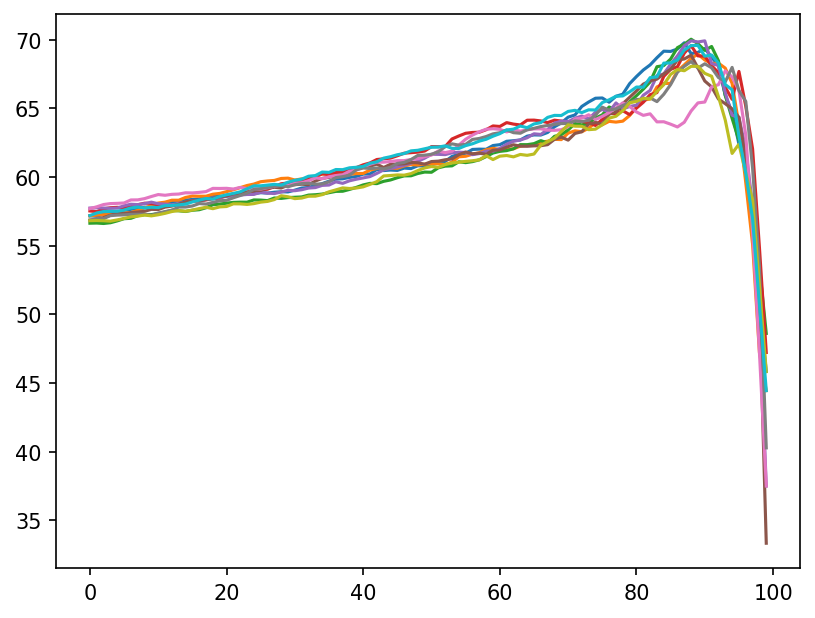

Training Members: ['0261', '0271', '0281', '0291', '0301', '0101', '0111', '0121', '0131']
Validation Member: 0141
Testing Member: 0251
files do not exist - loading data & saving
206/206 [==============================] - 0s 893us/step


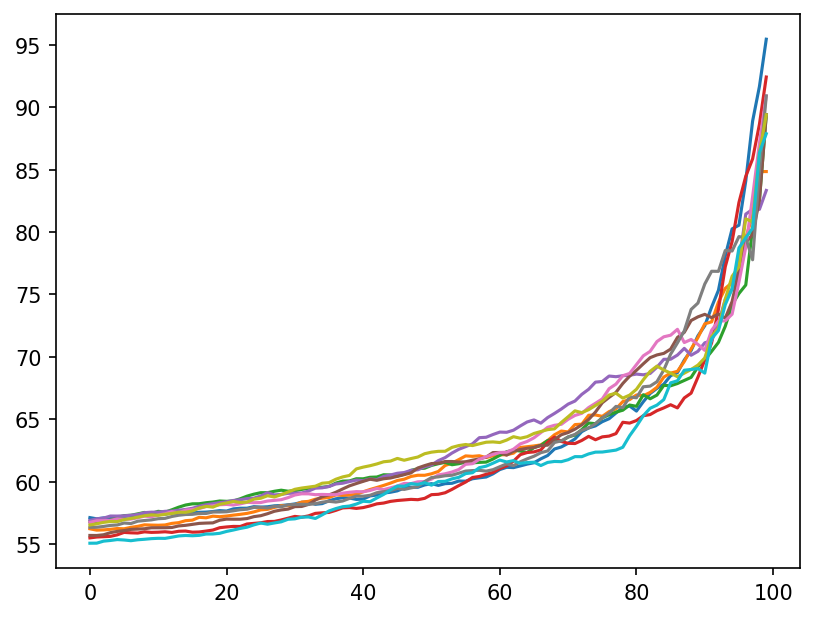

Training Members: ['0271', '0281', '0291', '0301', '0101', '0111', '0121', '0131', '0141']
Validation Member: 0151
Testing Member: 0261
files do not exist - loading data & saving
235/235 [==============================] - 0s 878us/step


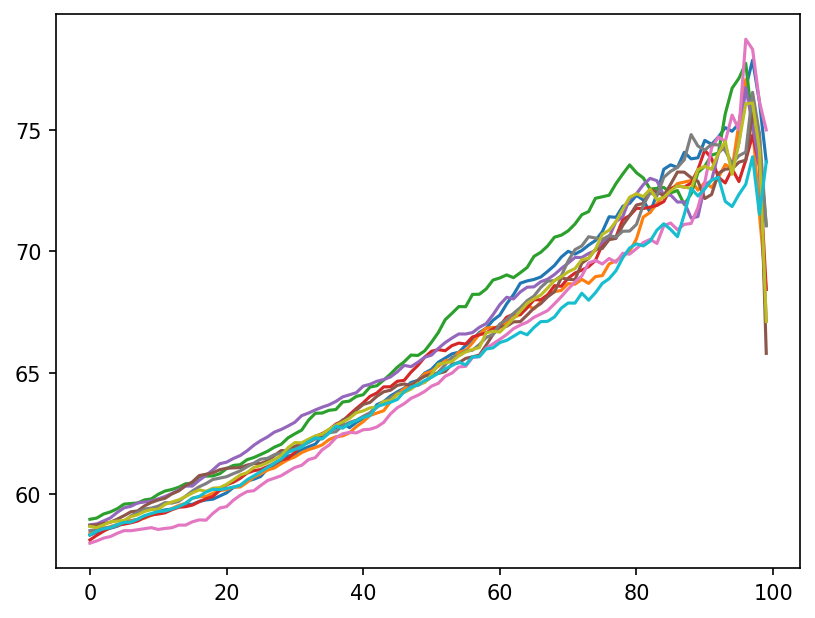

Training Members: ['0281', '0291', '0301', '0101', '0111', '0121', '0131', '0141', '0151']
Validation Member: 0161
Testing Member: 0271
files do not exist - loading data & saving
242/242 [==============================] - 0s 1ms/step


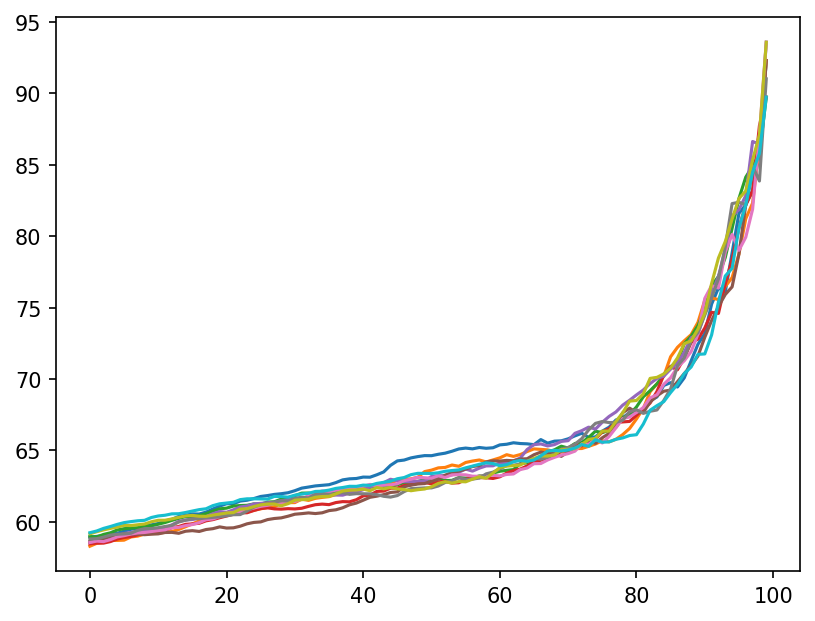

Training Members: ['0291', '0301', '0101', '0111', '0121', '0131', '0141', '0151', '0161']
Validation Member: 0171
Testing Member: 0281
files do not exist - loading data & saving
240/240 [==============================] - 0s 859us/step


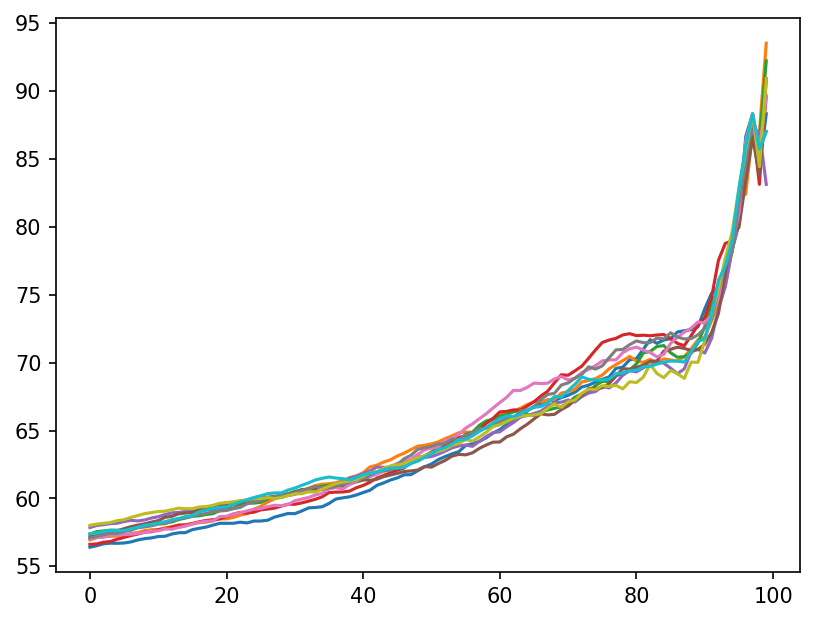

Training Members: ['0301', '0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171']
Validation Member: 0181
Testing Member: 0291
files do not exist - loading data & saving
238/238 [==============================] - 0s 819us/step


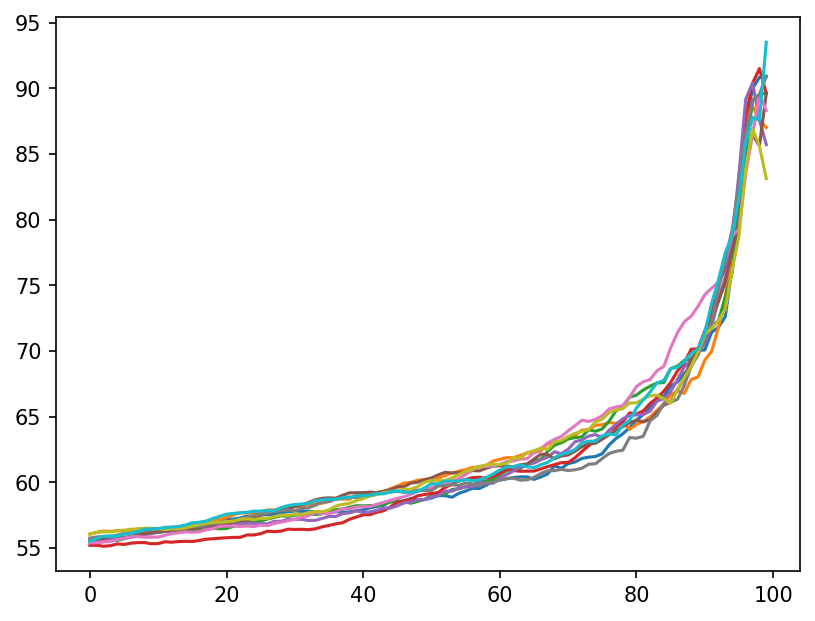

In [3]:
#----- SET UP & TRAIN NN -----
EXP_NAME = 'exp2_kfold'
hps = get_hp(EXP_NAME)
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for kk in range(20):
    print('Training Members: '+str(hps['train_mems'][kk]))
    print('Validation Member: '+str(hps['val_mems'][kk][0]))
    print('Testing Member: '+str(hps['test_mems'][kk][0]))
    
    
    _, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'][kk],
                                                      valmem = hps['val_mems'][kk][0],
                                                      testmem = hps['test_mems'][kk][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) 
    
    X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))
    
    
    acc_all = []
    for SEED in range(10):
        annfi_name = 'ann_60Eshift_'+EXP_NAME+'.'+str(kk)+'_seed'+str(SEED)+'.h5' 
        ann = tf.keras.models.load_model(base_dir+'train/saved_models/kfold/'+annfi_name)
        
        pred = ann.predict(X1test)
        acc = []
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)
    
        for q in range(100):
            iconf = np.where(predconf >= np.percentile(predconf,q=q))
            icorr = np.where(predval[iconf] == Y1test[iconf])
            
            acc.append((len(icorr[0])/len(iconf[0]))*100)
        plt.plot(acc)
        
        acc_all.append(acc)
    plt.show()
    
    np.save(base_dir+'test/confvsacc/kfold/confvsacc_ann1_60Eshift_'+EXP_NAME+'.'+str(kk)+'.npy', acc_all, allow_pickle=True)

In [7]:
# get SST data:
cvdp_path = '/glade/u/home/kjmayer/data/CESM2-LE/CVDP/'
ens      = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020']
ens_strt = ['1011','1031','1051','1071','1091','1111','1131','1151','1171','1191','1231','1231','1231','1231','1231','1231','1231','1231','1231','1231']

for e in range(len(ens)):
    cvdp_finame = 'CESM2-LENS_'+ens_strt[e]+'.'+ens[e]+'.cvdp_data.1850-2100.nc'
    if e == 0:
        nino34 = xr.open_dataset(cvdp_path+cvdp_finame,decode_times=False)['nino34']
    elif e > 0:
        temp_nino34 = xr.open_dataset(cvdp_path+cvdp_finame,decode_times=False)['nino34']
        nino34 = xr.concat([nino34,temp_nino34],dim='ens')

newtime = pd.date_range("1850-01-01", freq="MS", periods=len(nino34.time))
nino34['time'] = newtime                           
nino34 = nino34.where((nino34.time.dt.year >= 1950) & (nino34.time.dt.year <= 2015), drop = True)

nino34_ensmean = nino34.mean('ens')

nino34_detrended = detrend_members(data = nino34, 
                                   ensmean_data = nino34_ensmean, 
                                   npoly=3)

nino34_detrended_upsample = nino34_detrended.resample(time='1D').asfreq()
nino34_detrended_upsample = nino34_detrended_upsample.where(~((nino34_detrended_upsample.time.dt.month == 2) & (nino34_detrended_upsample.time.dt.day == 29)),drop=True)
nino34_detrended_upsample = nino34_detrended_upsample.ffill(dim='time')
nino34_detrended_upsample = nino34_detrended_upsample[:,6:-335] # 6: account for days 1-6 missing in X because of rolling mean; 
                                                                #-355: had to go through 2015 (not 2014) to get all days in Dec 2014 (not just 12-01-2014)

# nino34_detrended[0].plot()
# nino34_detrended_upsample[0].plot()

nino34_test = nino34_detrended_upsample[hps['test_mems'][0]-1,:-6][:-hps['LEAD']]
nino34_test_NDJF = nino34_test[nino34_test.time.dt.month.isin([11,12,1,2])]
nino34test = nino34_test_NDJF.isel(time = inew,drop=True)

0
235/235 [==============================] - 0s 1ms/step
1
235/235 [==============================] - 0s 1ms/step
2
235/235 [==============================] - 0s 1ms/step
3
235/235 [==============================] - 0s 1ms/step
4
235/235 [==============================] - 0s 1ms/step
5
235/235 [==============================] - 0s 1ms/step
6
235/235 [==============================] - 0s 1ms/step
7
235/235 [==============================] - 0s 1ms/step
8
235/235 [==============================] - 0s 1ms/step
9
235/235 [==============================] - 0s 1ms/step


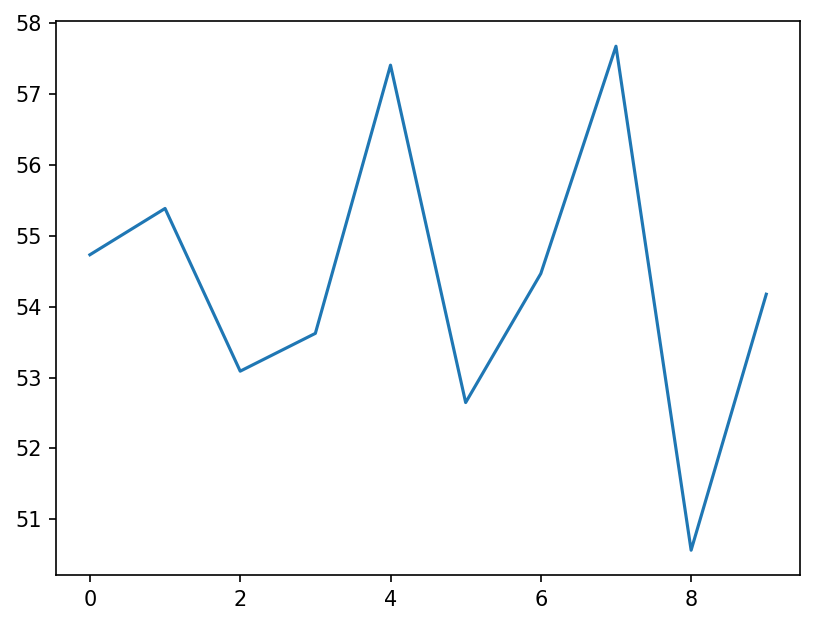

In [45]:

acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann_60Ebias_'+EXP_NAME+'_seed'+str(SEED)+'.h5' 
    ann = tf.keras.models.load_model(base_dir+'models/'+annfi_name)
    
    iENSO = (nino34test > 1) | (nino34test < -1)
    pred = ann.predict(X1test)
    
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)
    q = 80
    iconf = predconf >= np.percentile(predconf,q=q)
    
    iconfENSO = iconf & iENSO
    
    iconfcorrENSO = predval[iconfENSO] == Y1test[iconfENSO]
    
    # percent of predictions correct when the network is confident during an ENSO event
    acc_all.append((np.shape(np.where(iconfcorrENSO)[0])[0]/np.shape(np.where(iconfENSO)[0])[0])*100)
plt.plot(acc_all)



In [36]:
q = 80

iENSO = (nino34test > 1) | (nino34test < -1)

pred = ann.predict(X1test)
predconf = np.max(pred,axis=-1)
iconf = predconf >= np.percentile(predconf,q=q)

# fraction of confident predictions during ENSO:
iconfENSO = iENSO & iconf

print(np.shape(pred[iconfENSO])[0]/np.shape(pred[iconf])[0])

# fraction of ENSO days
print(np.shape(pred[iENSO])[0]/np.shape(pred)[0])

235/235 [==============================] - 0s 1ms/step
0.6390927284856571
0.6590605817987724


In [42]:
np.shape(np.where(iconf)[0])[0]

(1499,)